**Abstract** 
The main objective of this notebook is to compare different methods that help to detect spam messages. The author used logistic regression, polynomial naive Bayes, decision tree and linear vector supprot. 

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import spacy
import nltk
from nltk.corpus import stopwords

from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# Import data


In [3]:
df = pd.read_csv('dataset_spam.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
df.shape

(5572, 2)

The entire dataset contains 5572 messages with an assigned spam or ham class. 

In [5]:
df.describe(include='object')

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


# Checking if any duplicate records are present

In [6]:
duplicate=df[df.duplicated()] 
duplicate

,Category,Message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
duplicate = df[df.duplicated()] 
duplicate

,Category,Message


In [9]:
df.describe(include='object')

,Category,Message
count,5157,5157
unique,2,5157
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [10]:
df.shape

(5157, 2)

In [11]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

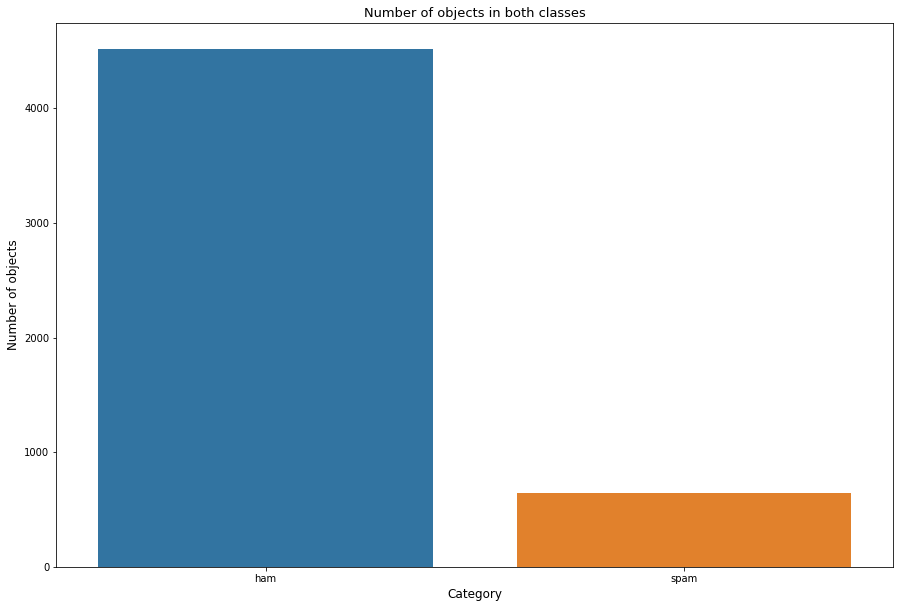

In [12]:
plt.figure(figsize=(15,10))
g =sns.countplot(x=df['Category'])
plt.title('Number of objects in both classes', size=13)
plt.ylabel('Number of objects', size =12)
plt.xlabel('Category', size=12)
plt.show()

As we can see in this dataset there is a strong disproportion of objects in classes

# Expand contractions

In [13]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))#create pattern for regex
def expand_contractions(s, contractions_dict=contractions_dict):# as input we provide each message and whole contractions_dict
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)
df['Message'] = df['Message'].apply(lambda x:expand_contractions(x))
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I do not think he goes to usf, he lives ar..."


In [14]:
df['Message'] = df['Message'].apply(lambda x:x.lower())

In [15]:
# Removing digits and words containing digits

df['Message'] = df['Message'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [16]:
# Removing punctuations

df['Message'] = df['Message'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [17]:
# removing extra 
df['Message']=df['Message'].apply(lambda x: re.sub(' +',' ',x))

In [18]:
df

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i do not think he goes to usf he lives aro...
...,...,...
5567,spam,this is the time we have tried contact u u hav...
5568,ham,will ü b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggestions
5570,ham,the guy did some bitching but i acted like id ...


In [19]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    rev = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w not in stopwords.words('english')]
    rev = ' '.join(rev)
    return rev

df['Message'] = df.Message.apply(lemmatize_text) #removinf stopworods like in, are, of, at, etc

In [20]:
# Creating text variable for ham

df_ham = df[df.Category == 'ham']

text_ham = " ".join(text for text in df_ham['Message'])

In [21]:
# Creating text variable for spam

df_spam = df[df.Category == 'spam']

text_spam = " ".join(text for text in df_spam['Message'])

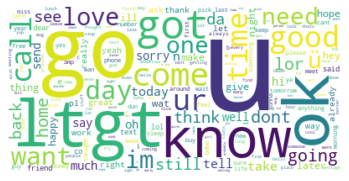

In [22]:
# Creating wordcloud for ham

ham_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_ham)
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

u, go, know, come, good, got, ok, time, ur, need, call etc. are some of the most common words in ham messages. 

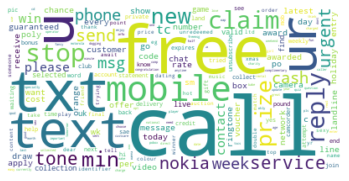

In [23]:
# Creating wordcloud for spam
spam_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_spam)
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

call, free, now, txt, reply, text, claim, prize, mobile, new, service, stop, etc. are some of the most common words in spam messages.


# NLP Methods to get to the root of dataset

## Tokenization 

To begin with, we need to split each word in  sentence in a separate string. For this we can use the nltk library and the word_tokenize function

In [24]:
from nltk.tokenize import word_tokenize
tokenized  = []
for article in df.Message:
    tokenized.append(word_tokenize(article))


In [25]:
df.iloc[0,1]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [26]:
tokenized[0]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat']

## Lemmatization

The next step is to replace the words with words without endings

In [27]:
from nltk.stem import PorterStemmer 
porter = PorterStemmer()
print('Root word for cats -->', porter.stem('cats'))
# print('Root word for cats -->', porter.stem('catss')) #wrong here
print('Root word for mice -->', porter.stem('mice'))

Root word for cats --> cat
Root word for mice --> mice


Load english model of NLP from spacy library

In [28]:
import spacy 
nlp = spacy.load('en_core_web_sm')
doc_exp = nlp("Apple is looking at buying U.K. startup for $1 billion") 
for token in doc_exp:
    print(token, '--->', token.lemma_)

Apple ---> Apple
is ---> be
looking ---> look
at ---> at
buying ---> buy
U.K. ---> U.K.
startup ---> startup
for ---> for
$ ---> $
1 ---> 1
billion ---> billion


In [29]:
lemmatized = []
for text in tokenized:
    c=[]
    for word in text:
        doc = nlp(word)
        for token in doc:
            c.append(token.lemma_)
    lemmatized.append(c)

In [30]:
lemmatized = [str(' '.join(sentance)) for sentance in lemmatized]
lemmatized

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts may text fa receive entry questionstd txt ratetc apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though',
 'freemsg hey darle week word back would like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune',
 'winner value network customer select receivea prize reward claim call claim code valid hour',
 'mobile month u r entitle update late colour mobile camera free call mobile update co free',
 'gon na home soon want talk stuff anymore tonight k cry enough today',
 'six chance win cash pound txt send cost day tsandc apply reply hl info',
 'urgent week free membership prize jackpot txt word claim tc wwwdbuknet lccltd pobox',
 'search right word thank brea

# NER - named entity recognition

In [31]:
doc_exp

Apple is looking at buying U.K. startup for $1 billion

In [32]:
entities = [(X.text, X.label_) for X in doc_exp.ents]
for entity in entities:
    print(entity)

('Apple', 'ORG')
('U.K.', 'GPE')
('$1 billion', 'MONEY')


# TfidfVectorizer

The whole idea behind TF-IDF is to find important words in a document  by finding those words that have a high frequency in that document but  not anywhere else in the corpus. For a document related to Computer  Science, these words could be – Computational, data, processor, etc. but  for an astronomical document, it would be- extraterrestrial, galactic,  black hole, etc

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [93]:
cv = CountVectorizer()
X = cv.fit_transform(df['Message']).toarray()
# X = cv.fit_transform(lemmatized).toarray()

le = LabelEncoder()
df["Category"] = le.fit_transform(df["Category"]) 
y = df["Category"]

In [94]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [95]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Category, Length: 5157, dtype: int64

In [96]:
df_train_x, df_test_x, df_y_train, df_y_test = train_test_split(df['Message'],df['Category'] , test_size=0.33, random_state=42)

In [97]:
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.33, random_state=42)

In [98]:
vectorizer = TfidfVectorizer(use_idf=True)
tfidf = vectorizer.fit_transform(df_train_x)

In [99]:
df_train_x[:10]

260                im parked next mini coming today think
3746                      aight let know gonna around usf
1965    honeybee said sweetest world god laughed amp s...
1186                                             annoying
2731                                  havent lei next mon
660                            premium phone service call
3984    nationwide auto centre something like newport ...
3919                need ke qi ü bored izzit suddenly thk
4659    message great doctor india drink appy fizz con...
4397                   dear mood cant drive brother drive
Name: Message, dtype: object

In [100]:
df_single_doc = pd.DataFrame(tfidf[2].T.todense(), index=vectorizer.get_feature_names(),columns=['TF-IDF'])
df_single_doc = df_single_doc.sort_values('TF-IDF', ascending=False)
df_single_doc.head(20)

,TF-IDF
god,0.367774
said,0.303205
sweetest,0.248456
laughed,0.248456
crack,0.248456
waitu,0.248456
gmgngegn,0.248456
havnt,0.248456
honeybee,0.248456
moral,0.236541


In [101]:
tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english')
tfidfvectorizer.fit(df_train_x)
tfidf_train = tfidfvectorizer.transform(df_train_x)
tfidf_term_vectors  = tfidfvectorizer.transform(df_test_x)
tfidf_term_vectors.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

# Logistic Regression

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
display(clf.predict(X_test)[:20])
display(y_test[:20])

display(clf.predict_proba(X_test[:20]))
print("Score of train data:", clf.score(X_train, y_train))
print("Score of test data:", clf.score(X_test, y_test))

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

3031    0
495     0
2942    0
3911    0
3360    1
2309    1
870     1
3425    1
690     1
1219    0
3433    1
2158    0
1939    0
4304    0
4167    0
5371    0
4505    0
2846    0
3070    0
5103    0
Name: Category, dtype: int64

array([[9.84964368e-01, 1.50356323e-02],
       [7.46178576e-01, 2.53821424e-01],
       [9.98683959e-01, 1.31604070e-03],
       [9.97917218e-01, 2.08278172e-03],
       [9.78278977e-01, 2.17210228e-02],
       [4.11627981e-02, 9.58837202e-01],
       [6.82589408e-05, 9.99931741e-01],
       [4.51184483e-01, 5.48815517e-01],
       [1.52302052e-01, 8.47697948e-01],
       [9.85775698e-01, 1.42243022e-02],
       [1.91963088e-01, 8.08036912e-01],
       [9.95626376e-01, 4.37362401e-03],
       [9.82068249e-01, 1.79317505e-02],
       [9.67602663e-01, 3.23973375e-02],
       [9.57607097e-01, 4.23929032e-02],
       [9.96514636e-01, 3.48536445e-03],
       [9.95753309e-01, 4.24669068e-03],
       [9.94999391e-01, 5.00060913e-03],
       [9.91259842e-01, 8.74015834e-03],
       [9.36708364e-01, 6.32916355e-02]])

Score of train data: 0.9947901591895804
Score of test data: 0.9782608695652174


This model perform very well on both datasets

## Count how many times model classified  sample properly

In [104]:
predict_test = clf.predict(X_test)
counterLR = 0
for i in range(len(predict_test)):
    if predict_test[i] ==list(y_test)[i]:
        counterLR+=1
print(f'Number of proper claification: {counterLR} over {len(predict_test):,}, so model has missclassified number of {len(predict_test)-counterLR} documents')

Number of proper claification: 1665 over 1,702, so model has missclassified number of 37 documents


## Other metrics

In [105]:
# F1 score and accuracy

f1_score_LR = f1_score(y_test, predict_test, average='weighted')
accuracy_LR = accuracy_score(y_test, predict_test)

print("F1 Score:", f1_score_LR)
print("Accuracy Score:", accuracy_LR)

F1 Score: 0.9775954147738879
Accuracy Score: 0.9782608695652174


In [106]:
print(classification_report(y_test, predict_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1483
           1       0.98      0.85      0.91       219

    accuracy                           0.98      1702
   macro avg       0.98      0.92      0.95      1702
weighted avg       0.98      0.98      0.98      1702



We note that precision for both categories is within 2% error which is a very good result. The 85% recall score indicates that the model made an error in 15% of the documents, in fact the documents turned out to be spam. F-1 score shows the combination of precision and recall which may indicate a very good model performance. 

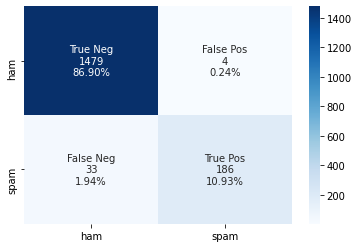

In [107]:
cm = confusion_matrix(y_test, predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
g.set_xticklabels(['ham','spam'])
g.set_yticklabels(['ham','spam'])
plt.show()

# Multinominal Naive Bayes

In [108]:
nb = MultinomialNB().fit(X_train, y_train)

In [109]:
print("Score of train data:", nb.score(X_train, y_train))
print("Score of test data:", nb.score(X_test, y_test))

Score of train data: 0.9901591895803183
Score of test data: 0.963572267920094


## Count how many times model classified  sample properly

In [110]:
y_predNB = nb.predict(X_test)

counterNB = 0
for i in range(len(y_predNB)):
    if y_predNB[i] ==list(y_test)[i]:
        counterNB+=1

print(f'Number of proper claification: {counterNB} over {len(y_predNB):,}, so model has missclassified number of {len(y_predNB)-counterNB} documents')

Number of proper claification: 1640 over 1,702, so model has missclassified number of 62 documents


## Other metrics

In [111]:
# F1 score and accuracy

f1_score_NB = f1_score(y_test, y_predNB, average='weighted')
accuracy_NB = accuracy_score(y_test, y_predNB)

print("F1 Score:", f1_score_NB)
print("Accuracy Score:", accuracy_NB)

F1 Score: 0.9647318114028985
Accuracy Score: 0.963572267920094


In [112]:
print(classification_report(y_test, y_predNB))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1483
           1       0.81      0.94      0.87       219

    accuracy                           0.96      1702
   macro avg       0.90      0.95      0.92      1702
weighted avg       0.97      0.96      0.96      1702



Compared to Logical Regression, we see here a much worse value for the precision metric, which may indicate that we managed to identify 81% of all cases belonging to this class. However, given the size of this class, i.e. 219, we can treat this as a good result. 

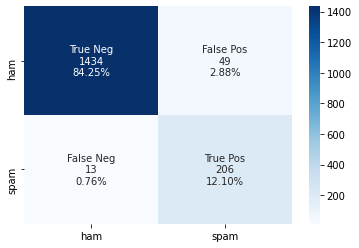

In [113]:
cm = confusion_matrix(y_test, y_predNB)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g=  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
g.set_xticklabels(['ham','spam'])
g.set_yticklabels(['ham','spam'])
plt.show()

# Decission Tree

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
cross_val_score(dtc, X_train, y_train, cv=10)

array([0.94508671, 0.95375723, 0.95953757, 0.94508671, 0.95953757,
       0.96811594, 0.96521739, 0.95362319, 0.96521739, 0.95942029])

In [115]:
dtc = dtc.fit(X_train, y_train)

In [116]:
print("Score of train data:", dtc.score(X_train, y_train))
print("Score of test data:", dtc.score(X_test, y_test))

Score of train data: 1.0
Score of test data: 0.9576968272620446


## Count how many times model classified  sample properly

In [117]:
y_predDTC = dtc.predict(X_test)

counterDTC = 0
for i in range(len(y_predDTC)):
    if y_predDTC[i] ==list(y_test)[i]:
        counterDTC+=1

print(f'Number of proper claification: {counterDTC} over {len(y_predDTC):,}, so model has missclassified number of {len(y_predDTC)-counterDTC} documents')

Number of proper claification: 1630 over 1,702, so model has missclassified number of 72 documents


## Other metrics

In [118]:
# F1 score and accuracy

f1_score_DTC = f1_score(y_test, y_predDTC, average='weighted')
accuracy_DTC = accuracy_score(y_test, y_predDTC)

print("F1 Score:", f1_score_DTC)
print("Accuracy Score:", accuracy_DTC)

F1 Score: 0.9576968272620446
Accuracy Score: 0.9576968272620446


In [119]:
print(classification_report(y_test, y_predDTC))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1483
           1       0.84      0.84      0.84       219

    accuracy                           0.96      1702
   macro avg       0.91      0.91      0.91      1702
weighted avg       0.96      0.96      0.96      1702



Surprisingly this model has the worst performance so far.

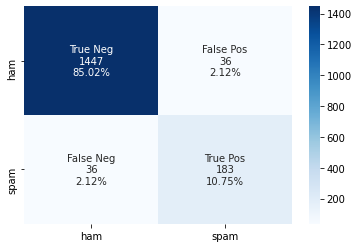

In [120]:
cm = confusion_matrix(y_test, y_predDTC)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
g.set_xticklabels(['ham','spam'])
g.set_yticklabels(['ham','spam'])
plt.show()

# Linear Support Vector

In [121]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
lsv = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
lsv = lsv.fit(X_train, y_train)
lsv

C:\Users\MSI\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [122]:
print("Score of train data:", dtc.score(X_train, y_train))
print("Score of test data:", dtc.score(X_test, y_test))

Score of train data: 1.0
Score of test data: 0.9576968272620446


## Count how many times model classified  sample properly

In [123]:
y_predlsv = lsv.predict(X_test)

counterlsv = 0
for i in range(len(y_predlsv)):
    if y_predlsv[i] ==list(y_test)[i]:
        counterlsv+=1
print(f'Number of proper claification: {counterlsv} over {len(y_predlsv):,}, so model has missclassified number of {len(y_predlsv)-counterlsv} documents')

Number of proper claification: 1640 over 1,702, so model has missclassified number of 62 documents


## Other metrics

In [124]:
# F1 score and accuracy

f1_score_lsv = f1_score(y_test, y_predlsv, average='weighted')
f1_score_lsv = accuracy_score(y_test, y_predlsv)

print("F1 Score:", f1_score_lsv)
print("Accuracy Score:", f1_score_lsv)

F1 Score: 0.963572267920094
Accuracy Score: 0.963572267920094


In [125]:
print(classification_report(y_test, y_predlsv))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1483
           1       0.81      0.93      0.87       219

    accuracy                           0.96      1702
   macro avg       0.90      0.95      0.92      1702
weighted avg       0.97      0.96      0.96      1702



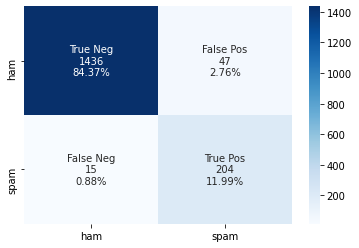

In [126]:
cm = confusion_matrix(y_test, y_predlsv)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g= sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
g.set_xticklabels(['ham','spam'])
g.set_yticklabels(['ham','spam'])
plt.show()

# Result comparision

In [127]:
values_for_df = {'model_name':['Logistic Regression','NaiveBayes','Decision Tree','Linear Suppor Vector'], 'predicted_good':[counterLR,counterNB,counterDTC,counterlsv],'All_test_samples':[len(predict_test),len(y_predNB),len(y_predDTC),len(y_predDTC)]}
df_comparision = pd.DataFrame.from_dict(values_for_df)
df_comparision

,model_name,predicted_good,All_test_samples
0,Logistic Regression,1665,1702
1,NaiveBayes,1640,1702
2,Decision Tree,1630,1702
3,Linear Suppor Vector,1640,1702


In [128]:
df_comparision['number_of_missclasified_samples'] = df_comparision.All_test_samples-df_comparision.predicted_good
df_comparision = df_comparision.sort_values(by='number_of_missclasified_samples')
df_comparision

,model_name,predicted_good,All_test_samples,number_of_missclasified_samples
0,Logistic Regression,1665,1702,37
1,NaiveBayes,1640,1702,62
3,Linear Suppor Vector,1640,1702,62
2,Decision Tree,1630,1702,72


In summary, the best model in this task was the Logistic Regression model. This model was wrong in only 37 papers. This means that the model was wrong in only 2% of the cases. The worst model among those mentioned turned out to be the decision tree 